PCA

conda create -n pca --> 
conda activate pca

In [150]:
%pip install torch
%pip install pandas
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [151]:
# Temporary fix to kernel not responding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def perform_svd(data):
    # Convert the data into a PyTorch tensor
    tensor_data = torch.Tensor(data.values)

    # Compute the SVD where S is the eigenvalues and V is the eigenvectors
    U, S, V = torch.linalg.svd(tensor_data)

    return U, S, V, tensor_data

def display_shape(S, V):
    print("Shape of eigenvalues (S):", S.shape)
    print("Shape of eigenvectors (V):", V.shape)

Perform PCA to the data you choose!

In [153]:
epsilon=100

folder_path = f'epsilon{epsilon}/'
file_path_t = f'../{folder_path}/test.data'
file_path_v = f'../{folder_path}/val.data'
file_path_s = f'../{folder_path}/gene.data'

In [154]:
from torch.utils.data import Dataset

# Define a custom dataset class
class TrajectoryDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load the real data
data_t = pd.read_csv(file_path_t, sep=" ", header=None)
data_t = torch.unique(torch.Tensor(data_t.values), dim=0)
data_t = pd.DataFrame(data_t)
labels_t = torch.ones(len(data_t))  # Label real data with 1

data_v = pd.read_csv(file_path_v, sep=" ", header=None)
data_v = torch.unique(torch.Tensor(data_v.values), dim=0)
data_v = pd.DataFrame(data_v)
labels_v = torch.ones(len(data_v))  # Label real data with 1

# Load the synthetic data
data_s = pd.read_csv(file_path_s, sep=" ", header=None)
data_s = torch.unique(torch.Tensor(data_s.values), dim=0)
data_s = pd.DataFrame(data_s)
labels_s = torch.zeros(len(data_s))  # Label synthetic data with 0

# Create datasets
dataset_r = TrajectoryDataset(pd.concat([data_t, data_v]).values, torch.cat([labels_t, labels_v]))
dataset_s = TrajectoryDataset(data_s.values, labels_s)

print("Real data shape:", dataset_r.data.shape)
print("Synthetic data shape:", dataset_s.data.shape)

Real data shape: (3380, 48)
Synthetic data shape: (8283, 48)


In [155]:
# Convert the numpy array to a pandas DataFrame
dataset_r_values = pd.DataFrame(dataset_r.data)

# Perform SVD on the converted DataFrame
U_r, S_r, V_r, real_data = perform_svd(dataset_r_values)

display_shape(S_r, V_r)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


In [156]:
# Convert the numpy array to a pandas DataFrame
dataset_s_values = pd.DataFrame(dataset_s.data)

# Perform SVD on the converted DataFrame
U_s, S_s, V_s, synthetic_data = perform_svd(dataset_s_values)

display_shape(S_s, V_s)

Shape of eigenvalues (S): torch.Size([48])
Shape of eigenvectors (V): torch.Size([48, 48])


Covariance matrix

In [157]:
def calculate_covariance_matrix(V, S):
    # Calculate the covariance matrix
    cov_matrix = torch.mm(torch.mm(V, torch.diag(S)), V.t())

    # Print the covariance matrix
    #print('Covariance Matrix:')
    #print(cov_matrix)
    #print('cov_matrix = ',cov_matrix.shape)


In [158]:
calculate_covariance_matrix(V_r, S_r)

calculate_covariance_matrix(V_s, S_s)

Variance of the components

In [159]:
def calculate_cumulative_variance(S):
    # Calculate the variance explained by each principal component
    variance_explained = (S ** 2) / torch.sum(S ** 2)

    # Calculate the cumulative variance explained
    cumulative_variance_explained = torch.cumsum(variance_explained, dim=0)

    return cumulative_variance_explained

In [160]:
cumulative_variance_real = calculate_cumulative_variance(S_r)
cumulative_variance_synthetic = calculate_cumulative_variance(S_s)

In [161]:
def scree_graph(cumulative_variance_real, cumulative_variance_synthetic):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance_real) + 1), cumulative_variance_real, linestyle='-', marker='x', color='red', label='Real Data')
    plt.plot(range(1, len(cumulative_variance_synthetic) + 1), cumulative_variance_synthetic, linestyle='-', marker='x', color='blue', label='Synthetic Data')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.title('Scree Graph')
    plt.show()

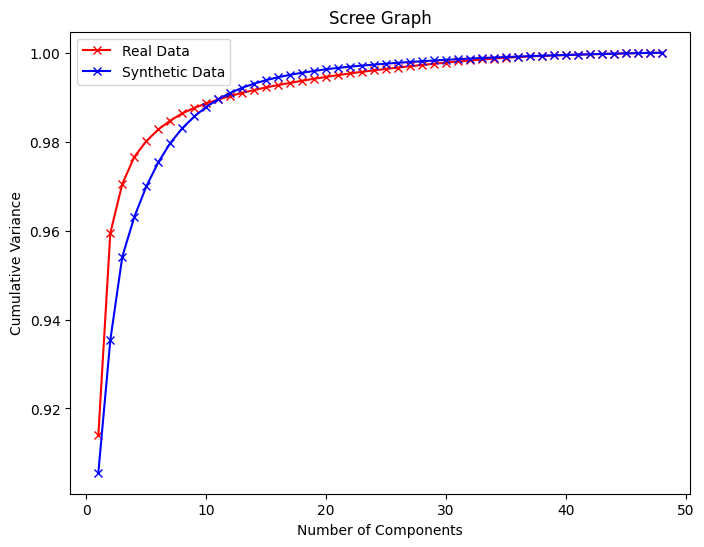

In [162]:
scree_graph(cumulative_variance_real, cumulative_variance_synthetic)

Decide: desired_variance = 1 - maximum information loss 

In [163]:
desired_variance = 0.95

In [164]:
def get_num_components(cumulative_variance_explained, desired_variance):
    num_components = torch.sum(cumulative_variance_explained < desired_variance) + 1
    return num_components.item()

# Not needed as we only project on the synthetic data
# num_components_needed_real = get_num_components(cumulative_variance_real, desired_variance)
# print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed_real, " components")


num_components_needed_syn = get_num_components(cumulative_variance_synthetic, desired_variance)
print("Number of principal components needed for a cumulative variance explained of", desired_variance, ":", num_components_needed_syn, " components")

Number of principal components needed for a cumulative variance explained of 0.95 : 3  components


In [165]:
# Project the real_data onto the plane formed by the principal components
new_coordinates_real = torch.matmul(real_data,V_s[:, :num_components_needed_syn])

# Project the real_data onto the plane formed by the principal components
new_coordinates_synthetic = torch.matmul(synthetic_data,V_s[:, :num_components_needed_syn])

In [168]:
# Plotting the real and synthetic new coordinates
def new_coordinates_comparison(new_coordinates_real, new_coordinates_synthetic):
    plt.figure(figsize=(8, 6))
    plt.scatter(new_coordinates_real[:, 0], new_coordinates_real[:, 1], label='Original', s=0.3)
    plt.scatter(new_coordinates_synthetic[:, 0], new_coordinates_synthetic[:, 1], label='Synthetic', s=0.3)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'PCA of Real and Synthetic Data for e=\'{epsilon}\'')
    plt.legend()
    plt.savefig(f'pca_\'{epsilon}\'.png')
    plt.show()

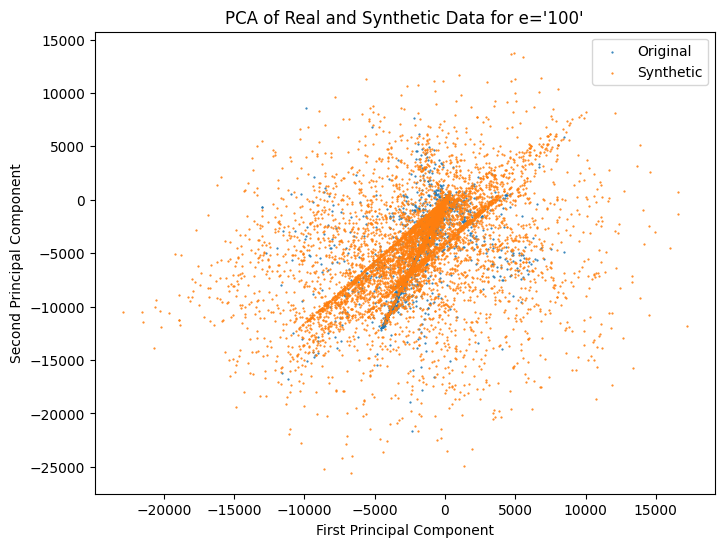

In [169]:
new_coordinates_comparison(new_coordinates_real, new_coordinates_synthetic)